# Проект e-commerce: вариант 1

[0. Знакомство с данными](#0)

[1. Сколько у нас пользователей, которые совершили покупку только один раз?](#1)

[2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?](#2)

[3. По каждому товару определить, в какой день недели товар чаще всего покупается?](#3)

[4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?](#4)

[5.1. Выполните когортный анализ пользователей?](#51)

[5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.](#52)

[5. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.](#6)


***
<a id="0"></a>
#  Знакомство с данными

In [2]:
import pandas as pd
import seaborn as sns
sns.set(
        font_scale = 2,
        style      = "whitegrid",
        rc         = {'figure.figsize' : (20,7)}
        )
df_customers  = pd.read_csv('//mnt/HC_Volume_18315164/home-jupyter/jupyter-v-gavristov/olist_customers_dataset.csv') 
df_orders     = pd.read_csv('//mnt/HC_Volume_18315164/home-jupyter/jupyter-v-gavristov/olist_orders_dataset.csv')
df_items      = pd.read_csv('//mnt/HC_Volume_18315164/home-jupyter/jupyter-v-gavristov/olist_order_items_dataset.csv')

In [3]:
df_customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [4]:
df_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [5]:
df_items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


Посмотрим: чем отличаются customer_id и customer_unique_id

In [6]:
df_customers.groupby('customer_unique_id')\
            .customer_zip_code_prefix\
            .count()\
            .sort_values(ascending = False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
                                    ..
a925c3e5df82fdc6082f1383d2834998     1
a92605ec492805540520d3a73aaeeb6e     1
a926aae38267e7f54e67de9b5775d0a5     1
a926cfc9bc7b082335de50450f48eec9     1
0000366f3b9a7992bf8c76cfdf3221e2     1
Name: customer_zip_code_prefix, Length: 96096, dtype: int64

customer_unique_id - уникальны для пользователей, но не для таблицы пользователей

In [7]:
df_customers.loc[df_customers.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'].head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14186,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
15321,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
16654,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP


Видим, что для одного пользователя может быть несколько customer_id
Посмотрим что такое customer_id

In [8]:
df_customers.customer_id.nunique()

99441

In [9]:
df_customers.customer_id.nunique() == len(df_customers) 

True

customer_id уникальны для таблицы заказчиков

In [10]:
df_orders.order_id.nunique() == df_orders.customer_id.nunique() == len(df_orders)

True

То есть в каждом заказе есть уникальный id заказа (order_id) и уникальный id заказчика (customer_id) и это суть одно и тоже - уникальный id заказа. Только в таблицу customers передается customer_id, а в таблицу items передается order_id. 
Сравним таблицы заказов и заказчиков

In [11]:
len(df_orders) == len(df_customers)

True

<a id="merge"></a>Число записей в таблицах orders и customers одинаковое. А точнее **эти две таблицы - это одна и также таблица, разделенная на две части со связью через customer_id**. Для будущих целей соотнесения заказчиков с заказами их позже можно будет объединить.

### Посмотрим на заказы

In [12]:
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [13]:
df_orders[['order_purchase_timestamp',
           'order_approved_at',
           'order_delivered_carrier_date',
           'order_delivered_customer_date',
           'order_estimated_delivery_date']] = df_orders[['order_purchase_timestamp',
                                                           'order_approved_at',
                                                           'order_delivered_carrier_date',
                                                           'order_delivered_customer_date',
                                                           'order_estimated_delivery_date']]\
                                                           .apply(pd.to_datetime)


In [14]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Посмотрим на графики

Посмотрим на все созданные заказы по дням

In [15]:
df_for_plots = df_orders

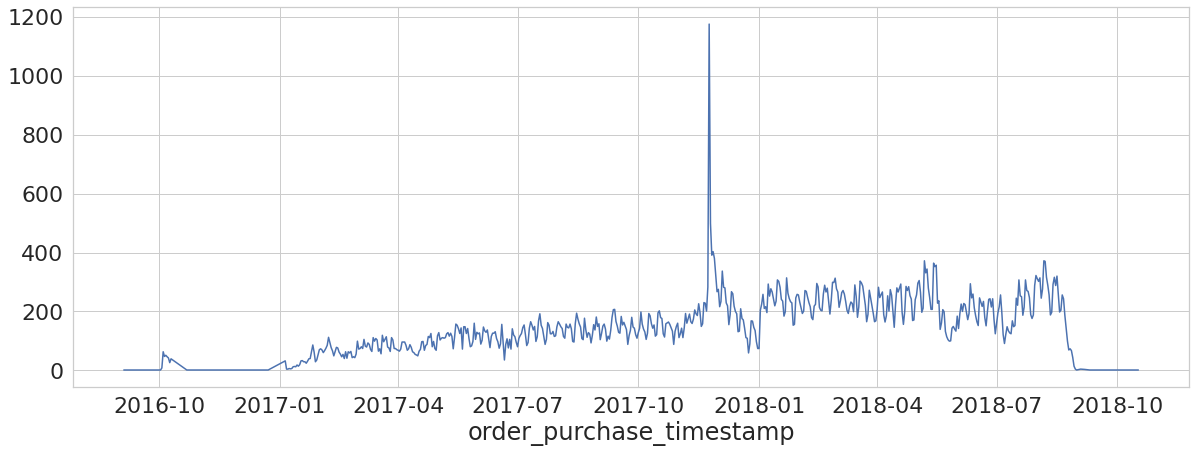

In [16]:
df_for_plots_orders_cnt = df_for_plots.groupby(df_for_plots.order_purchase_timestamp.dt.date).order_id.count()
sns.lineplot(x = df_for_plots_orders_cnt.index, y = df_for_plots_orders_cnt.values)

какая-то аномалия была 24.11.2017

In [17]:
df_for_plots_orders_cnt.sort_values(ascending = False)

order_purchase_timestamp
2017-11-24    1176
2017-11-25     499
2017-11-27     403
2017-11-26     391
2017-11-28     380
              ... 
2018-09-26       1
2018-09-29       1
2018-10-01       1
2018-10-03       1
2016-09-04       1
Name: order_id, Length: 634, dtype: int64

Проверим какие бывают статусы заказов

In [18]:
df_for_plots.groupby('order_status').order_id.count()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_id, dtype: int64

Глянем графики заказов по разным статусам

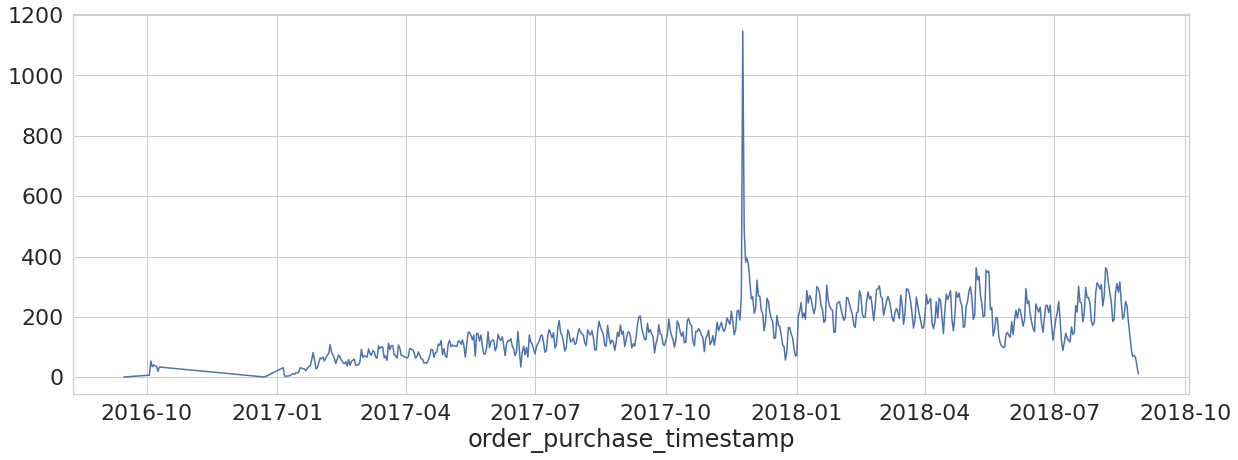

In [19]:
df_for_plots_orders_delivered = df_for_plots.query("order_status == 'delivered'").groupby(df_for_plots.order_purchase_timestamp.dt.date).order_id.count()
sns.lineplot(x = df_for_plots_orders_delivered.index, y = df_for_plots_orders_delivered.values)

In [20]:
df_for_plots_orders_delivered.sort_values(ascending = False)

order_purchase_timestamp
2017-11-24    1147
2017-11-25     487
2017-11-27     395
2017-11-26     382
2017-11-28     372
              ... 
2017-01-06       4
2017-01-07       4
2017-01-08       4
2016-12-23       1
2016-09-15       1
Name: order_id, Length: 612, dtype: int64

График доставленных заказов очень близок к графику созданных заказов. Почти все что было создано - было получено покупателями, то есть, заказы в аномалии реальные

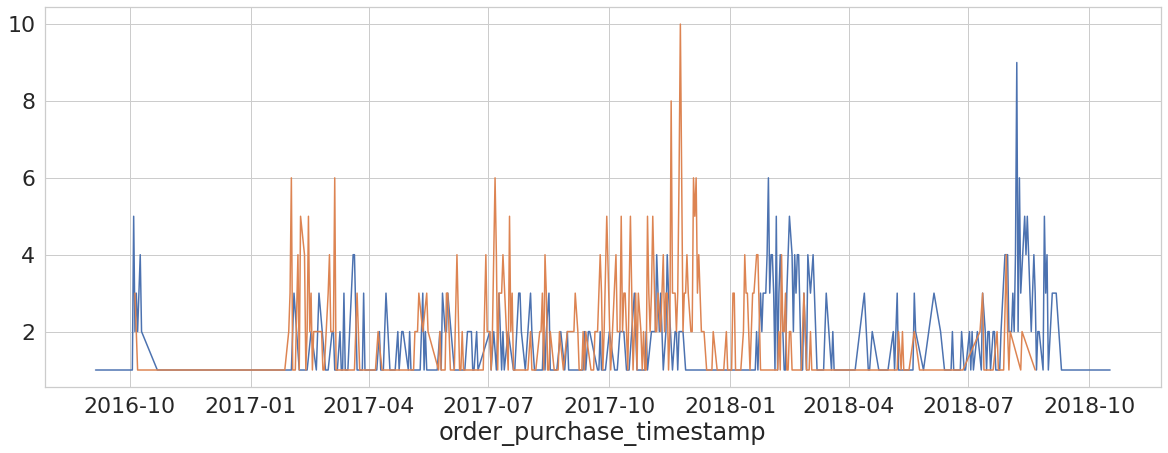

In [21]:
df_for_plots_orders_canceled = df_for_plots.query("order_status == 'canceled'").groupby(df_for_plots.order_purchase_timestamp.dt.date).order_id.count().sort_values()
df_for_plots_orders_unavailable = df_for_plots.query("order_status == 'unavailable'").groupby(df_for_plots.order_purchase_timestamp.dt.date).order_id.count().sort_values()
sns.lineplot(x = df_for_plots_orders_canceled.index, y = df_for_plots_orders_canceled.values)
sns.lineplot(x = df_for_plots_orders_unavailable.index, y = df_for_plots_orders_unavailable.values)

Отмененные и недоступные заказы распределены более-менее ровно

### Посмотрим на пользователей

In [22]:
df_cstms_unq = len(df_customers.groupby('customer_unique_id',as_index = False))
df_cstms_more_than_ones = df_customers.groupby('customer_unique_id',as_index = False)\
                      .agg({'customer_id':'count'})\
                      .sort_values('customer_id', ascending = False)\
                      .query('customer_id > 1')\
                      .customer_id.count()
print(f' Всего покупателей {df_cstms_unq} \n Из них разместили более 1 заказа {df_cstms_more_than_ones}')

 Всего покупателей 96096 
 Из них разместили более 1 заказа 2997


Очень небольшое число покупателей заказы повторно.

In [23]:
df_customers.groupby(['customer_state']).agg({'customer_id' : 'count'}).sort_values('customer_id', ascending = False).head(5)

,customer_id
customer_state,
SP,41746
RJ,12852
MG,11635
RS,5466
PR,5045


Явно выраженный штат-лидер по числу заказов, а с учетом небольшого числа повторных заказов - и по числу заказчиков.

In [24]:
df_customers.groupby(['customer_state', 'customer_city']).agg({'customer_id' : 'count'}).sort_values('customer_id', ascending = False).head(5)

,,customer_id
customer_state,customer_city,
SP,sao paulo,15540
RJ,rio de janeiro,6882
MG,belo horizonte,2773
DF,brasilia,2131
PR,curitiba,1521


А так же выдающийся город-чемпион

### Посмотрим на товары

In [25]:
df_items.groupby('seller_id').seller_id.count().sort_values(ascending = False)

seller_id
6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
                                    ... 
3fefda3299e6dfaea3466ef346a3571a       1
b9de031b671cd48b28fae9d828cbf2b4       1
2235cf78d3e2073a88146a9cb60f0dd0       1
b86a47b3366e3b5424a7b225781f4908       1
7d81e74a4755b552267cd5e081563028       1
Name: seller_id, Length: 3095, dtype: int64

Выраженных лидеров поставщиков нет

In [26]:
df_items.sort_values('price', ascending = False).head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
3556,0812eb902a67711a1cb742b3cdaa65ae,1,489ae2aa008f021502940f251d4cce7f,e3b4998c7a498169dc7bce44e6bb6277,2017-02-16 20:37:36,6735.0,194.31


In [27]:
df_items.sort_values('freight_value', ascending = False).head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
73486,a77e1550db865202c56b19ddc6dc4d53,1,ec31d2a17b299511e7c8627be9337b9b,257e61d3251fb5efb9daadddbc2cf7ca,2018-04-25 06:55:13,979.0,409.68


нет ничего дороже 7000 и тяжелее 410

In [28]:
df_items.groupby('order_id').product_id.count().sort_values(ascending = False)

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
a6e8ad5db31e71f5f12671af561acb4a     1
a6e963c11e80432334e984ead4797a8b     1
a6e9b80a7636eb8dd592dbb3e20d0a91     1
a6e9d106235bcf1dda54253686d89e99     1
00010242fe8c5a6d1ba2dd792cb16214     1
Name: product_id, Length: 98666, dtype: int64

Максимальное число позиций в одном заказе - 21 шт
Но самое странное что в таблице нет колнки количество.
Посмотрим внимательно на чемпионский по ассортименту заказ

In [29]:
df_items.loc[df_items.order_id == '8272b63d03f5f79c56e9e4120aec44ef'].groupby('product_id').seller_id.count()

product_id
05b515fdc76e888aada3c6d66c201dff    10
270516a3f41dc035aa87d220228f844c    10
79ce45dbc2ea29b22b5a261bbb7b7ee7     1
Name: seller_id, dtype: int64

Оказывается он состоит всего из трех товаров, а проблема отсутствия колонки с количеством решается по принципу - одна строка - 1 шт

Посмотрим сколько же реально товаров входит в заказы

In [30]:
t = df_items.groupby(['order_id','product_id'],as_index = False)\
        .agg({'seller_id':'count'})\
        .sort_values(['order_id', 'product_id','seller_id'], ascending = True)
t.groupby('order_id', as_index = False)\
 .agg({'seller_id':'count'})\
 .sort_values('seller_id', ascending = False)\
 .rename(columns = {'seller_id':'cnt'})\
 .query('cnt > 1')

,order_id,cnt
77909,ca3625898fbd48669d50701aba51cd5f,8
48309,7d8f5bfd5aff648220374a2df62e84d5,7
46116,77df84f9195be22a4e9cb72ca9e8b4c2,7
66653,ad850e69fce9a512ada84086651a2e7d,7
36443,5efc0b7fe9df7f0c567404abaa4d25fc,6
...,...,...
96744,fb085529373f03634a84fa2358deedcd,2
75282,c35c0040e09990a95e79c617fafe8c10,2
31465,518ca81bf7a1b719e32d6847b6afff85,2
92256,ef43d5664bd1ab24fd6b38b5a8ca3cf6,2


В заказ с самым широким ассортиментов вошло всего 8 позиций.
Заказов содержащих болеее 1 товара - 3236 из около 100 000
Проверим себя, посмотрим на самый ассортиментный заказ

In [31]:
df_items.loc[df_items.order_id == 'ca3625898fbd48669d50701aba51cd5f']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
89007,ca3625898fbd48669d50701aba51cd5f,1,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,309.0,1.84
89008,ca3625898fbd48669d50701aba51cd5f,2,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,33.9,1.84
89009,ca3625898fbd48669d50701aba51cd5f,3,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67
89010,ca3625898fbd48669d50701aba51cd5f,4,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67
89011,ca3625898fbd48669d50701aba51cd5f,5,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15
89012,ca3625898fbd48669d50701aba51cd5f,6,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,109.9,0.15
89013,ca3625898fbd48669d50701aba51cd5f,7,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15
89014,ca3625898fbd48669d50701aba51cd5f,8,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,63.7,0.15
89015,ca3625898fbd48669d50701aba51cd5f,9,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68
89016,ca3625898fbd48669d50701aba51cd5f,10,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68


Похоже, все так и есть. 

Получается, что таблица items содержит построчную раскладку каждого заказа из orders.

А значит мы можем через группировки посчитать сумму по каждому заказу и суммарный вес заказа
Сначала посчитаем суммы для одинаковых товаров в одинаковых заказах

In [32]:
df_sum_and_wght = df_items.groupby(['order_id','product_id'],as_index = False)[['price','freight_value']]\
        .sum()\
        .sort_values('price', ascending = True)
df_sum_and_wght

,order_id,product_id,price,freight_value
79096,c5bdd8ef3c0ec420232e668302179113,8a3254bee785a526d548a81a9bc3c9be,0.85,22.30
44154,6e864b3f0ec71031117ad4cf46b7f2a1,8a3254bee785a526d548a81a9bc3c9be,0.85,18.23
25085,3ee6513ae7ea23bdfab5b9ab60bffcb5,8a3254bee785a526d548a81a9bc3c9be,0.85,18.23
96770,f1d5c2e6867fa93ceee9ef9b34a53cbf,46fce52cef5caa7cc225a5531c946c8b,2.20,7.39
93193,e8bbc1d69fee39eee4c72cb5c969e39d,310dc32058903b6416c71faff132df9e,2.29,7.78
...,...,...,...,...
98056,f5136e38d1a14a4dbd87dff67da82701,1bdf5e6731585cf01aa8169c7028d6ad,6499.00,227.66
102041,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00,193.21
3243,0812eb902a67711a1cb742b3cdaa65ae,489ae2aa008f021502940f251d4cce7f,6735.00,194.31
46140,736e1922ae60d0d6a89247b851902527,19936fa4f614ee0590d3b77ac83fd648,7160.00,114.88


А теперь посчитаем суммы стоимости и веса для всех товаров в одинаковых заказах

In [33]:
df_sum_and_wght = df_sum_and_wght.groupby('order_id', as_index = False)[['price','freight_value']]\
 .sum()\
 .sort_values('price', ascending = True)
df_sum_and_wght

,order_id,price,freight_value
42562,6e864b3f0ec71031117ad4cf46b7f2a1,0.85,18.23
24174,3ee6513ae7ea23bdfab5b9ab60bffcb5,0.85,18.23
93208,f1d5c2e6867fa93ceee9ef9b34a53cbf,2.20,7.39
89758,e8bbc1d69fee39eee4c72cb5c969e39d,2.29,7.78
21805,38bcb524e1c38c2c1b60600a80fc8999,2.90,8.72
...,...,...,...
94439,f5136e38d1a14a4dbd87dff67da82701,6499.00,227.66
98298,fefacc66af859508bf1a7934eab1e97f,6729.00,193.21
3130,0812eb902a67711a1cb742b3cdaa65ae,6735.00,194.31
44467,736e1922ae60d0d6a89247b851902527,7160.00,114.88


Посмотрим на максимальный по стоимости заказ

In [34]:
df_items.loc[df_items.order_id == '03caa2c082116e1d31e67e9ae3700499']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1647,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1648,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1649,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1650,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1651,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1652,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1653,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1654,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01


Посмотрим на минимальный по стоимости заказ

In [35]:
df_items.loc[df_items.order_id == '03caa2c082116e1d31e67e9ae3700499']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1647,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1648,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1649,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1650,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1651,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1652,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1653,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1654,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01


In [36]:
Похоже - все верно, теперь у нас есть таблица с суммарными весами и суммами заказов
Можем посмотреть на графики распределения заказов по сумме и весу

SyntaxError: invalid syntax (<ipython-input-36-83cd67f3fe1d>, line 1)

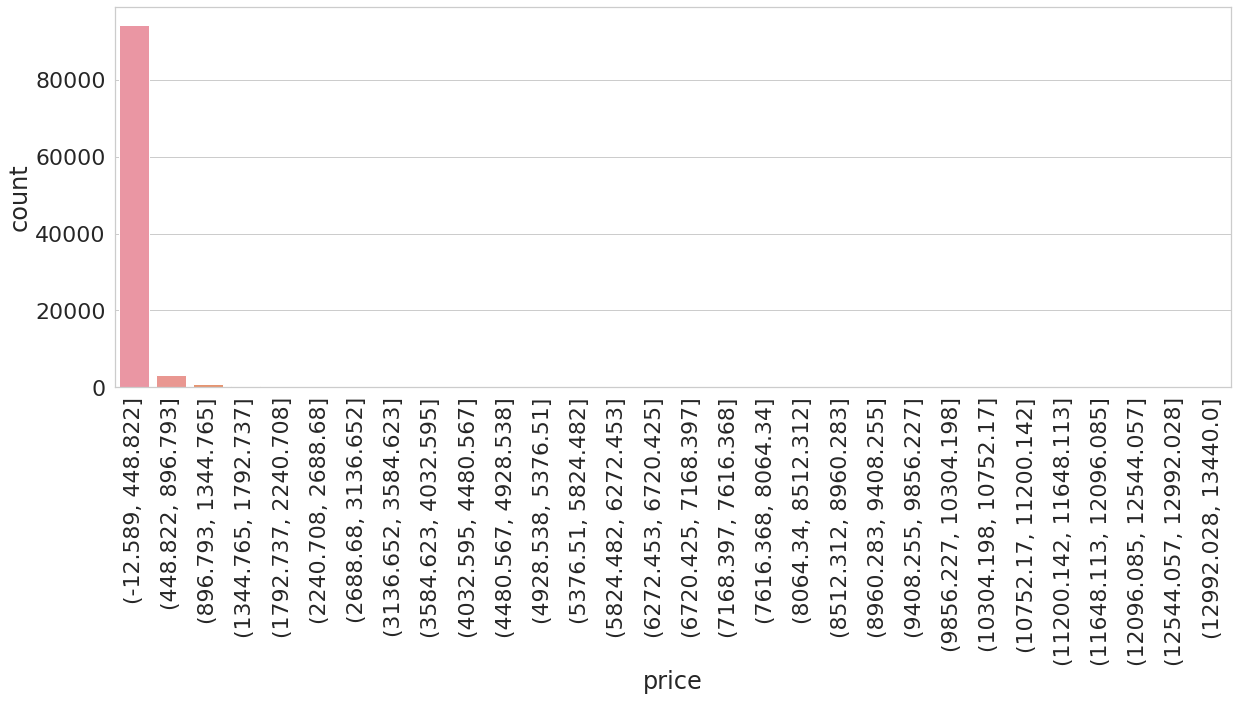

In [37]:
ax = sns.countplot(data=df_sum_and_wght, x=pd.cut(df_sum_and_wght.price, 30))
ax.tick_params(axis='x', labelrotation=90)

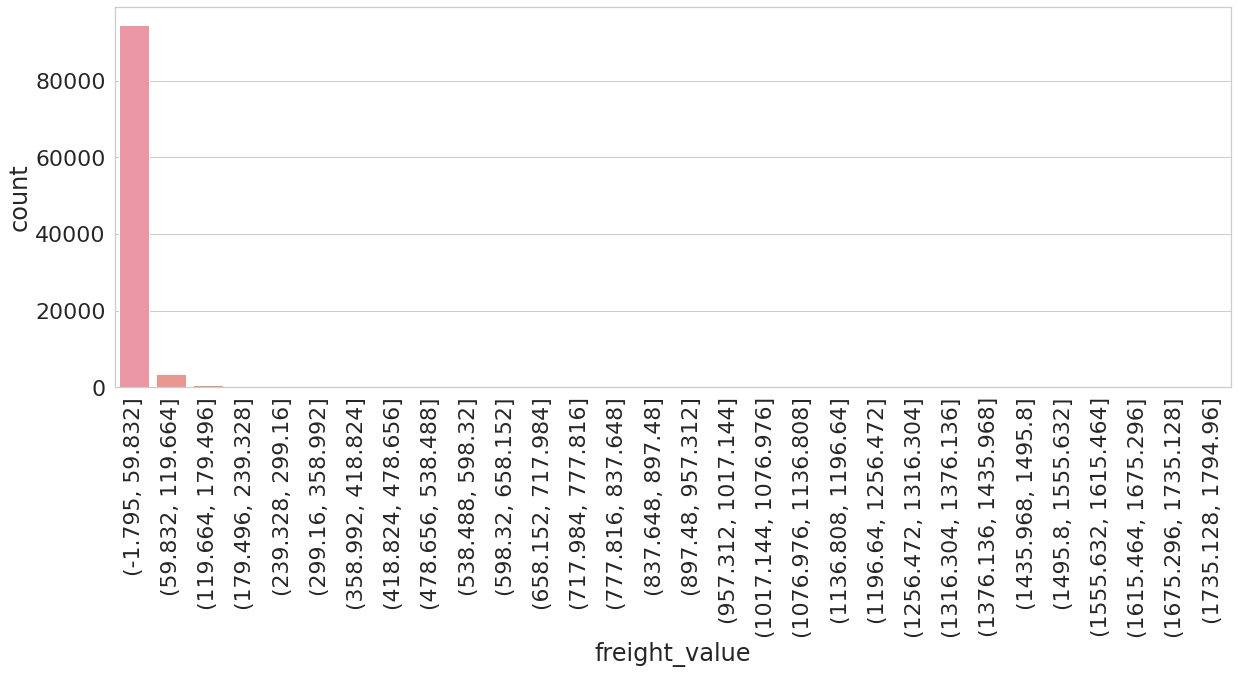

In [38]:
bx = sns.countplot(data=df_sum_and_wght, x=pd.cut(df_sum_and_wght.freight_value, 30))
bx.tick_params(axis='x', labelrotation=90)

Как видим, у нас преобладают легкие и недорогие заказы. При этом графики настолько похожи, что кажется, что цена товара зависит от его веса.

***
<a id="1"></a>
#  Сколько у нас пользователей, которые совершили покупку только один раз?

Пользователь - это заказчик, он же customer. Заказчик определается по customer_unique_id. У одного заказчик customer_unique_id может быть несколько заказов customer_id или order_id

Схлопнем таблицы заказов и заказчиков в одну по customer_id (почему это можно сделать см **[тут](#merge)**)

Таким образом мы получим в одной таблице и уникальных заказчиков, и заказы и даты и статусы

In [39]:
df_co = df_customers.merge(df_orders, on='customer_id', how='left')
df_co 

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


Отберем заказчиков, разместивших только 1 заказ

In [40]:
df_1 = df_co.groupby('customer_unique_id', as_index = False)\
     .agg({'customer_zip_code_prefix' : 'count'})\
     .rename(columns = {'customer_zip_code_prefix' : 'orders_cnt'})\
     .sort_values('orders_cnt', ascending = False)\
     .query('orders_cnt == 1').customer_unique_id.to_list()
df_the_only_one = df_co.loc[df_co.customer_unique_id.isin(df_1)]
df_the_only_one

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


Посмотрим на распределение статусов заказов

In [41]:
df_the_only_one.groupby('order_status').agg({'order_purchase_timestamp' : 'count'})

,order_purchase_timestamp
order_status,
approved,2
canceled,533
created,4
delivered,90379
invoiced,298
processing,286
shipped,1032
unavailable,565


 Осталось отобрать из размещенных заказов покупки
 
 Нас интересуют статусы 
- "delivered" - товар получен заказчиком
- "unavailable" - недоступный товар вряд ли можно считать покупкой
- "canceled" -  это не покупка, надо проверить

Плюс поля

- order_approved_at - время подтверждения ОПЛАТЫ заказа. Если время есть, значит заказ оплачен
- order_delivered_customer_date - время передачи заказа заказчику. Если время есть, значит заказ получен

Смотрим "delivered" и order_delivered_customer_date

In [42]:
df_the_only_one.loc[df_the_only_one.order_status == 'delivered']\
    .order_delivered_customer_date\
    .isnull()\
    .sum()


8

только для 8 заказов со статусом "delivered" оказалось не заполнено время получения заказа заказчиком

In [43]:
df_the_only_one.loc[df_the_only_one.order_status == 'delivered']\
    .order_delivered_customer_date\
    .sort_values()\
    .tail(10)

65131   2018-10-11 16:41:14
5128    2018-10-17 13:22:46
9034                    NaT
12030                   NaT
13357                   NaT
51668                   NaT
85377                   NaT
87172                   NaT
89194                   NaT
97677                   NaT
Name: order_delivered_customer_date, dtype: datetime64[ns]

Других значенний в поле времнеи доставки кроме времени и NAN нет, ни пробелов, ни нулей, ничего такого. То есть, все что не NaN - даты
Посмотрим на эти заказы с NaN в order_delivered_customer_date

In [44]:
df_the_only_one.loc[df_the_only_one.order_status == 'delivered']\
    .loc[df_the_only_one.order_delivered_customer_date.isnull() == True]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
9034,5e89028e024b381dc84a13a3570decb4,2f17c5b324ad603491521b279a9ff4de,18255,quadra,SP,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
12030,28c37425f1127d887d7337f284080a0f,175378436e2978be55b8f4316bce4811,9431,ribeirao pires,SP,20edc82cf5400ce95e1afacc25798b31,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19
13357,29f0540231702fda0cfdee0a310f11aa,1bd06a0c0df8b23dacfd3725d2dc0bb9,12445,pindamonhangaba,SP,2ebdfc4f15f23b91474edf87475f108e,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
51668,ec05a6d8558c6455f0cbbd8a420ad34f,13467e882eb3a701826435ee4424f2bd,18520,cerquilho,SP,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
85377,dd1b84a7286eb4524d52af4256c0ba24,cce5e8188bf42ffb3bb5b18ff58f5965,7261,guarulhos,SP,ab7c89dc1bf4a1ead9d6ec1ec8968a84,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
87172,cfda40ca8dd0a5d486a9635b611b398a,3bc508d482a402715be4d5cf4020cc81,13170,sumare,SP,e69f75a717d64fc5ecdfae42b2e8e086,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
89194,4f1d63d35fb7c8999853b2699f5c7649,ebf7e0d43a78c81991a4c59c145c75db,13560,sao carlos,SP,0d3268bad9b086af767785e3f0fc0133,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
97677,e08caf668d499a6d643dafd7c5cc498a,d77cf4be2654aa70ef150f8bfec076a6,91330,porto alegre,RS,2d858f451373b04fb5c984a1cc2defaf,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Как видим все эти 8 заказов оплачены и по статусу - доставлены.

**Поэтому дальше будем считать, что эти заказы доставлены не смотря на отсутствующую дату доставки**

In [45]:
df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False]\
    .order_status\
    .isnull()\
    .sum()

0

По заказам с заполненными датами получения заказа клиентом нет пропусков в заполнении статусов заказа.
Проверим какими статусами они заполнены.

In [46]:
len(df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].order_status) == \
len(df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].loc[df_the_only_one.order_status == 'delivered'].order_status)


False

В строках с заполненной датой получения не все статусы "delivered"
Проверим что за отличные от "delivered" статусы еще встречаются

In [47]:
df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].loc[df_the_only_one.order_status != 'delivered'].order_status

27088    canceled
50569    canceled
57499    canceled
59705    canceled
76291    canceled
77039    canceled
Name: order_status, dtype: object

Видим, что для 6 заказов указана дата получения заказчиком, но при этом стоит статус заказа canceled
Проверим только ли эти два статуса встречаются

In [48]:
len(df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].order_status) == \
len(df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].loc[df_the_only_one.order_status == 'delivered'].order_status)\
+ len(df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].loc[df_the_only_one.order_status == 'canceled'].order_status)

True

Да, других статусов кроме delivered и canceled у заказов с заполненной датой доставки нет. Посмотрим на заказы canceled

In [49]:
df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].loc[df_the_only_one.order_status == 'canceled']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
27088,6c57e6119369185e575b36712766b0ef,59a7bb642795ddc85534fbd5f7360334,20091,rio de janeiro,RJ,770d331c84e5b214bd9dc70a10b829d0,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
50569,1bccb206de9f0f25adc6871a1bcf77b2,6a04c8339c44b23e189446216a494569,32071,contagem,MG,1950d777989f6a877539f53795b4c3c3,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
57499,bf609b5741f71697f65ce3852c5d2623,f9af3bfab584769f34c314b222d34263,20091,rio de janeiro,RJ,8beb59392e21af5eb9547ae1a9938d06,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
59705,70fc57eeae292675927697fe03ad3ff5,b8b8726af116a5cfb35b0315ecef9172,22770,rio de janeiro,RJ,65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
76291,de4caa97afa80c8eeac2ff4c8da5b72e,d93a22bb52bb2f41a7267b8a02370781,88058,florianopolis,SC,2c45c33d2f9cb8ff8b1c86cc28c11c30,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08
77039,5cdec0bb8cbdf53ffc8fdc212cd247c6,2f96790fba243100730c8d1185dd2f25,5846,sao paulo,SP,dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30


Как мы видим, **у этих заказов указана дата доставки заказчику**, то есть они были доставлены, **по ним была получена оплата**, но **согласно статусу они были отменены**

Посмотрим на дату и время движений этих заказов

In [50]:
delivered_but_canceled = df_the_only_one.loc[df_the_only_one.order_delivered_customer_date.isnull() == False].loc[df_the_only_one.order_status == 'canceled'].order_id.to_list()
delivered_but_canceled

['770d331c84e5b214bd9dc70a10b829d0',
 '1950d777989f6a877539f53795b4c3c3',
 '8beb59392e21af5eb9547ae1a9938d06',
 '65d1e226dfaeb8cdc42f665422522d14',
 '2c45c33d2f9cb8ff8b1c86cc28c11c30',
 'dabf2b0e35b423f94618bf965fcb7514']

In [51]:
df_items.loc[df_items.order_id.isin(delivered_but_canceled)].merge(df_orders, on = 'order_id')


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,1950d777989f6a877539f53795b4c3c3,1,e435ceb7ced9b8446defd858630454ed,2a61c271b1ac763450d846849783e922,2018-02-23 20:56:05,29.99,14.10,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
1,2c45c33d2f9cb8ff8b1c86cc28c11c30,1,e24f73b7631ee3fbb2ab700a9acaa258,0cbcee27c791afa0cdcb08587a2013a8,2016-10-14 10:40:50,135.00,18.51,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08
2,65d1e226dfaeb8cdc42f665422522d14,1,9c7bdf67b06b419aefb93cfdfc96c55d,ed49da7cadefc454d6a67de249eab240,2016-10-21 16:24:43,21.50,14.11,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
3,770d331c84e5b214bd9dc70a10b829d0,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 15:07:11,249.90,14.03,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
4,8beb59392e21af5eb9547ae1a9938d06,1,c66def7098f4d87751f40c3a4855ced1,46dc3b2cc0980fb8ec44634e21d2718e,2016-10-13 14:34:31,99.99,11.23,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
5,dabf2b0e35b423f94618bf965fcb7514,1,473795a355d29305c3ea6b156833adf5,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-13 13:36:59,59.90,0.48,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
6,dabf2b0e35b423f94618bf965fcb7514,2,7cd29da0653abeb444703cc5a957f479,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-13 13:36:59,49.90,29.94,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30


Не видно какой-то закономерности кроме:
1. Неединичное совпадение до секунды shipping_limit_date и order_delivered_carrier_date  - явные проблемы с внесением данных в этих колонках
2. Неединичное превышение order_delivered_carrier_date над shipping_limit_date, чего вроде как быть не может согласно описанию shipping_limit_date - **максимальная дата доставки** продавцом для передачи заказа партнеру по логистике

С учетом сказанного буду считать, что **в данных 6 случаях статус canceled поставлен ошибочно из этих 6 canceled - были доставлены и покупка состоялась**

а значит **статус заказа delivered с плюсовой поправкой на эти 6 заказов определяет получен ли заказ клиентом**

### Что есть покупка?

Строго говоря, **доставленный (принятый и не отмененный) заказчиком заказ - и есть покупка**. 

Оплата юридически не связана с покупкой товара. Перечисление денег и получение товара лишь накладывает соотвествующие обязательства на стороны.

Из данных невозможно понять о юридических или физических лицах идет речь. Применительно к юрлицам порядок оплаты и получения товара определяется договором с каждым конкретным юрлицом. 

Кроме того, право перехода собственности, как правило, возникает в момент подписания накладной, оплата же лишь погашает обязательство заказчика по оплате произведенной покупки.

Тем не менее, введу три варианта:

1. Заказ получен
2. Заказ оплачен
3. Заказ получен и оплачен - да, да, у нас там есть несколько полученных заказазов, по которым не проставлена дата подтверждения

И пусть он сам выбирает нужную схему расчета сообразно своему миропониманию.

**Считаем заказчиков при принципу "заказ получен"** = delivery + 6

In [52]:
# Всего одноразовых клиентов
a = df_customers.customer_unique_id.nunique()
# Одноразовых клиентов с одним доставленным заказом
cnt1 = len(df_the_only_one.loc[df_the_only_one.order_status == 'delivered']) + 6

print(f' Если считать покупку по статусу delivery, то заказчиков, совершивших одну покупку {cnt1}')

 Если считать покупку по статусу delivery, то заказчиков, совершивших одну покупку 90385


**Считаем заказчиков при принципу "заказ оплачен"**

Признаком оплаты является корректно заполненное поле order_approved_at 

In [53]:
df_the_only_one.loc[df_the_only_one.order_approved_at.isnull() != True]\
         .groupby('order_status')\
         .order_purchase_timestamp\
         .count()

order_status
approved           2
canceled         454
delivered      90366
invoiced         298
processing       286
shipped         1032
unavailable      565
Name: order_purchase_timestamp, dtype: int64

Очевидно, что определение покупки через оплату лишено смысла в случае статусов canceled и unavailable, поскольку эти статусы все  видимо поставлены не просто так

Все остальнные статусы как-будто говорят о том, что заказ оплачен, находится или находился в работе, нет отснований считать его отмененным. 

Так что **число оплаченных заказов будем корректировать на отмененные и недоступные заказы**

In [54]:
df_orders.query("order_status == 'canceled' and order_delivered_customer_date.notnull()")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


**Все оплаченные заказы со статусом canceled (кроме все тех же 6) не были доставлены заказчику** - нет данных в поле order_delivered_customer_date, а значит все они (кроме 6) были отменены

посмотрим статус unavailable

In [55]:
df_orders.query("order_status == 'unavailable' and order_delivered_customer_date.notnull()")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


**Все оплаченные заказы со статусом unavailable не были доставлены заказчику** - нет данных в поле order_delivered_customer_date, а значит все они были отменены

In [56]:
# Всего одноразовых клиентов
a = df_customers.customer_unique_id.nunique()
# Одноразовых клиентов с одним оплаченным заказом
cnt2 = len(df_the_only_one.loc[df_the_only_one.order_approved_at.isnull() != True]\
            .loc[df_the_only_one.order_status != 'canceled']\
            .loc[df_the_only_one.order_status != 'unavailable']) + 6

print(f' Если считать покупку по статусу "заказ оплачен", то заказчиков, совершивших одну покупку {cnt2} ')

 Если считать покупку по статусу "заказ оплачен", то заказчиков, совершивших одну покупку 91990 


**Считаем заказчиков при принципу "заказ оплачен и доставлен"**

In [57]:
# Всего одноразовых клиентов
a = df_customers.customer_unique_id.nunique()
# Одноразовых клиентов с одним оплаченным заказом
cnt3 = len(df_the_only_one.loc[df_the_only_one.order_approved_at.isnull() != True]\
            .loc[df_the_only_one.order_status != 'canceled']\
            .loc[df_the_only_one.order_status != 'unavailable']\
            .loc[df_the_only_one.order_status == 'delivered']) + 6

print(f' Если считать покупку по статусу "заказ оплачен и доставлен", то заказчиков, совершивших одну покупку {cnt3} ')

 Если считать покупку по статусу "заказ оплачен и доставлен", то заказчиков, совершивших одну покупку 90372 


In [58]:
df_the_only_one.loc[df_the_only_one.order_approved_at.isnull() == True]\
            .loc[df_the_only_one.order_status == 'delivered']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
8970,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
13890,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
20863,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
22703,07a2a7e0f63fd8cb757ed77d4245623c,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,51eb2eebd5d76a24625b31c33dd41449,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29
39286,d85919cb3c0529589c6fa617f5f43281,c094ac95fcd52f821809ec232a7a6956,95795,sao vendelino,RS,3c0b8706b065f9919d0505d3b3343881,delivered,2017-02-17 15:53:27,NaT,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23
41493,74bebaf46603f9340e3b50c6b086f992,f79be7c08dd24b72d34634f1b89333a4,65110,sao jose de ribamar,MA,2babbb4b15e6d2dfe95e2de765c97bce,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31
44050,684cb238dc5b5d6366244e0e0776b450,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP,c1d4211b3dae76144deccd6c74144a88,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
52849,a3d3c38e58b9d2dfb9207cab690b6310,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG,2eecb0d85f281280f79fa00f9cec1a95,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20
60039,2127dc6603ac33544953ef05ec155771,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP,e04abd8149ef81b95221e88f6ed9ab6a,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
61049,f67cd1a215aae2a1074638bbd35a223a,bc1896dc77f49e6dec880445a9b443a3,21020,rio de janeiro,RJ,88083e8f64d95b932164187484d90212,delivered,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21


**как мы видим у нас есть доставленные заказы без указания информации об оплате**

In [59]:
len(df_the_only_one.loc[df_the_only_one.order_approved_at.isnull() == True]\
            .loc[df_the_only_one.order_status == 'delivered'])

13

И таковых - 13 штук

## Подведем итоги по первому вопросу:

In [60]:
print(f' Cколько пользователей совершили покупку только один раз?\n \
\n \
Ответ:\n \
\n \
Если считать покупку по факту получения заказа клиентом: {cnt1}\n \
Если считать покупку по факту оплаты заказа клиентом: {cnt2}\n \
Если считать покупку по факту получения клиентом оплаченного заказа: {cnt3}')

 Cколько пользователей совершили покупку только один раз?
 
 Ответ:
 
 Если считать покупку по факту получения заказа клиентом: 90385
 Если считать покупку по факту оплаты заказа клиентом: 91990
 Если считать покупку по факту получения клиентом оплаченного заказа: 90372


<a id="2"></a>
# Вопрос №2 "Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)"

In [61]:
df_month_failed = df_orders.loc[df_orders.order_status != 'delivered']
df_month_failed

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [62]:
df_month_failed['invoiced']=df_orders.order_status.loc[df_orders.order_status == 'invoiced']
df_month_failed['shipped']=df_orders.order_status.loc[df_orders.order_status == 'shipped']
df_month_failed['processing']=df_orders.order_status.loc[df_orders.order_status == 'processing']
df_month_failed['canceled']=df_orders.order_status.loc[df_orders.order_status == 'canceled']
df_month_failed['unavailable']=df_orders.order_status.loc[df_orders.order_status == 'unavailable']
df_month_failed

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,invoiced,shipped,processing,canceled,unavailable
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,invoiced,NaN,NaN,NaN,NaN
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,NaN,shipped,NaN,NaN,NaN
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,invoiced,NaN,NaN,NaN,NaN
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,NaN,NaN,processing,NaN,NaN
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,NaN,shipped,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,NaN,NaN,NaN,canceled,NaN
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06,NaN,NaN,processing,NaN,NaN
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27,NaN,NaN,NaN,canceled,NaN
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,NaN,NaN,NaN,NaN,unavailable


In [63]:
df_orders.order_purchase_timestamp.sort_values()

4541    2016-09-04 21:15:19
4396    2016-09-05 00:15:34
10071   2016-09-13 15:24:19
30710   2016-09-15 12:16:38
83078   2016-10-02 22:07:52
                ...        
50387   2018-09-29 09:13:03
88500   2018-10-01 15:30:09
31891   2018-10-03 18:55:29
68373   2018-10-16 20:16:02
60938   2018-10-17 17:30:18
Name: order_purchase_timestamp, Length: 99441, dtype: datetime64[ns]

In [64]:
df_month_failed.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
invoiced                                 object
shipped                                  object
processing                               object
canceled                                 object
unavailable                              object
dtype: object

In [65]:
df_failed_status = df_month_failed.set_index('order_purchase_timestamp')\
               .resample("M")\
               .agg({'customer_id':'count',
                     'invoiced':'count',
                     'shipped':'count',
                     'processing':'count',
                     'canceled':'count',
                     'unavailable':'count'})\
                .rename(columns = {'customer_id':'total_undelivered'})
df_failed_status

,total_undelivered,invoiced,shipped,processing,canceled,unavailable
order_purchase_timestamp,,,,,,
2016-09-30,3,0,1,0,2,0
2016-10-31,59,18,8,2,24,7
2016-11-30,0,0,0,0,0,0
2016-12-31,0,0,0,0,0,0
2017-01-31,50,12,16,9,3,10
2017-02-28,127,11,21,32,17,45
2017-03-31,136,3,45,23,33,32
2017-04-30,101,14,49,10,18,9
2017-05-31,154,16,55,23,29,31


**Посмотрим на статус invoiced**

In [66]:
df_orders.loc[df_orders.order_status == 'invoiced']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
455,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,NaT,NaT,2017-08-28
1833,51b0dccc8596ce37a930dff2d63a10a2,31bf1057b00f14804278590bbac18b1b,invoiced,2017-05-05 22:34:48,2017-05-05 22:45:12,NaT,NaT,2017-06-06
2116,5504eaa5a86eb25fa666cf2e6b96c701,a30be38e1ed0ffb39b318bf1d15e98d9,invoiced,2017-11-29 08:33:06,2017-11-29 08:56:23,NaT,NaT,2017-12-20
...,...,...,...,...,...,...,...,...
98414,41ad2ae32ee66c07ef3b0301ba02ad27,5c7f8d14a0a12198d1d07167d7d343b3,invoiced,2017-11-24 15:54:47,2017-11-24 19:33:24,NaT,NaT,2017-12-18
98624,9ffb325177b96c422447e3b9ee9a6270,e4079117ea0dc8bc27274e34c4796515,invoiced,2018-05-10 19:11:18,2018-05-10 19:37:27,NaT,NaT,2018-06-05
98845,021dac6e3120485db6a77474aa21b979,c40f7f00e91eb8a0da1e58484380a796,invoiced,2017-11-24 22:46:09,2017-11-25 01:53:42,NaT,NaT,2017-12-15
99031,c526fe83c01c48066394ff5d81f9ab9a,6c678c38f3a0874b7bfeeb2d5fb22876,invoiced,2018-08-07 11:11:30,2018-08-07 11:25:01,NaT,NaT,2018-08-17


In [67]:
df_orders.loc[df_orders.order_status == 'invoiced']\
         .loc[df_orders.order_approved_at.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [68]:
df_orders.loc[df_orders.order_status == 'invoiced']\
         .loc[df_orders.order_estimated_delivery_date.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


**Статус invoiced проставляется после получения оплаты по счету**. У нас нет счетов со статусом invoiced, по которым бы не было оплаты.

**Посмотрим на статус processing**

In [69]:
df_orders.loc[df_orders.order_status == 'processing']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09
741,6a6c7d523fd59eb5bbefc007331af717,d954782ec6c0e911292c8a80757ef28d,processing,2017-11-24 20:09:33,2017-11-24 23:15:15,NaT,NaT,2017-12-20
1192,745e1d4a7f8c4b548881788d4113bb1d,7198d7088442e4ddfe553353d8ddc957,processing,2017-11-17 06:34:36,2017-11-18 02:15:40,NaT,NaT,2017-12-12
1516,1d52ba7197c7acebbb4f826f6585536f,c9c7fe860d602373a9e93f8bfe9d877a,processing,2017-02-13 18:32:55,2017-02-13 18:43:55,NaT,NaT,2017-04-04
...,...,...,...,...,...,...,...,...
97400,dcdfc540e42725663242bb884c28f0a6,38972104038aa68fcc61277dbf6e7ca9,processing,2017-10-30 10:46:44,2017-10-30 11:09:55,NaT,NaT,2017-11-23
97666,e471815e7114cdb474064f7dbb1a8b67,092c9316ae71b2fe43e526043f351967,processing,2017-12-20 11:00:02,2017-12-20 11:10:43,NaT,NaT,2018-02-02
98089,10951d02d64917a34959abeb8130601e,3e6754e591ff3568ccc5bf69a649918c,processing,2018-02-13 21:02:02,2018-02-15 04:11:21,NaT,NaT,2018-03-13
99140,aea0db338150b526dde24f6fd953a5ed,379a02efdc6a56bd27f99b95fc2f6c06,processing,2017-12-26 21:56:13,2017-12-26 22:05:26,NaT,NaT,2018-01-26


**вообще не понятно чем от отличается от invoiced**

**Посмотрим на статус shipped**

In [70]:
df_orders.loc[df_orders.order_status == 'shipped']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13
299,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03
...,...,...,...,...,...,...,...,...
98534,a59ef0abffbef8ddaae23600b6ee6604,49e64271fb8eeb19851dc7e850e92204,shipped,2017-11-06 17:35:49,2017-11-07 06:31:44,2017-11-07 18:57:39,NaT,2017-11-24
98779,dab8a6c6bd6ec448df5b3a6b6cb887bc,394653a10cab83cad40d7e2713f3ab89,shipped,2018-07-14 10:12:51,2018-07-16 12:30:58,2018-07-16 14:34:00,NaT,2018-08-03
98932,492aed3c33bac22a8e04138319829283,58466c1166c377a56f6b2ae0d93ffbc0,shipped,2018-07-06 16:26:47,2018-07-06 16:35:10,2018-07-10 12:27:00,NaT,2018-07-26
99113,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-06-23 13:40:11,2018-07-04 13:51:00,NaT,2018-07-24


In [71]:
df_orders.loc[df_orders.order_status == 'shipped']\
         .loc[df_orders.order_delivered_carrier_date.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


**Статус shipped проставляется после передачи заказа в службу доставки**. У нас нет счетов со статусом shipped, по которым бы не была бы проставлена дата передачи.

**Посмотрим на статус canceled**

In [72]:
df_orders.loc[df_orders.order_status == 'canceled']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
...,...,...,...,...,...,...,...,...
98791,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99143,6560fb10610771449cb0463c5ba12199,0d07d0a588caf93cc66b7a8aff86d2fe,canceled,2017-10-01 22:26:25,2017-10-01 22:35:22,NaT,NaT,2017-10-27
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


Статус canceled проставляется на всех этапах вне зависимости от оплаты и передачи в доставку. Можно предположить, что **заказы с таким статусом отменяются по просьбе заказчика**

**Посмотрим на статус unavailable**

In [73]:
df_orders.loc[df_orders.order_status == 'unavailable']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27
...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [74]:
df_orders.loc[df_orders.order_status == 'unavailable']\
         .loc[df_orders.order_approved_at.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


**Статус unavailable проставляется только на оплаченные заказы.**

In [75]:
unvlbld_orders = df_orders.loc[df_orders.order_status == 'unavailable'].order_id.to_list()
len(unvlbld_orders)

609

In [76]:
df_f = df_items.loc[df_items.order_id.isin(unvlbld_orders)].merge(df_orders, on = 'order_id')
f_list = df_f.order_id.to_list()
df_f

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,1a47da1d66c70489c8e35fe2b5433ab7,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07
1,2fd1c83dd4714cf3cf796fffb6c8de62,1,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
2,2fd1c83dd4714cf3cf796fffb6c8de62,2,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
3,3c3ca08854ca922fe8e9cedfd6841c8a,1,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30
4,4dd47e84e6b8ff4a63d0b8425e6d788e,1,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24
5,54bb06e1ca86bd99ee2a8d6288bf4ede,1,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12
6,dc18a044b56ed174037ca164cdf2e921,1,faa268ecc8a8434cb4ebee091b3222d6,f0563bacf40c311f1c4d3d6b67b8a7a7,2016-10-21 16:18:52,1199.00,28.78,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29


In [77]:
len(df_orders)

99441

In [78]:
df_items.order_id.nunique()

98666

**Из 609 заказов со статусом unavailable до таблицы с товарами дошли только 6, остальные даже не принимались в работу.**
Судя по всему **статус проставляется в случае если при попытке заказать товар у поставщика под оплаченный заказ выясняется, что товар закончился и поступлений в разумные сроки не ожидается.**
Причем в 6 случаях это стало сюрпризом даже для поставщика, потому что он принял заказ в работу, в результате чего наша компания отразила заказ в items, и уже затем поставщик обнаружил,что не сможет произвести отрузку.

In [79]:
f_items = df_f.product_id.to_list()
f_dates = df_f.order_purchase_timestamp.dt.date.to_list()

In [80]:
df_f_full = df_items.merge(df_orders, on = 'order_id')
df_f_full.loc[df_f_full.product_id.isin(f_items)].loc[df_f_full.order_purchase_timestamp.dt.date.isin(f_dates)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2554,05bfcf9e287cad216cadb8a850f8db5c,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-10 16:05:52,249.90,17.59,51cc1e38d0489d588d7a687da73b2458,delivered,2016-10-06 10:47:15,2016-10-06 16:05:51,2016-10-30 10:54:35,2016-11-07 11:18:58,2016-11-30
2555,05bfcf9e287cad216cadb8a850f8db5c,2,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-10 16:05:52,249.90,17.59,51cc1e38d0489d588d7a687da73b2458,delivered,2016-10-06 10:47:15,2016-10-06 16:05:51,2016-10-30 10:54:35,2016-11-07 11:18:58,2016-11-30
5999,0d9664d8da1dc4337269071b39e19423,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-10 22:37:21,249.90,17.59,64c17343b6c53ee761fd232e84384848,delivered,2016-10-06 22:00:27,2016-10-06 22:37:21,2016-10-10 22:37:21,2016-10-27 13:36:27,2016-11-30
11558,1a47da1d66c70489c8e35fe2b5433ab7,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07
20902,2fd1c83dd4714cf3cf796fffb6c8de62,1,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
20903,2fd1c83dd4714cf3cf796fffb6c8de62,2,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
26470,3c3ca08854ca922fe8e9cedfd6841c8a,1,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30
34411,4dd47e84e6b8ff4a63d0b8425e6d788e,1,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24
37340,54bb06e1ca86bd99ee2a8d6288bf4ede,1,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12
52286,770d331c84e5b214bd9dc70a10b829d0,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 15:07:11,249.90,14.03,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29


In [81]:
f_list

['1a47da1d66c70489c8e35fe2b5433ab7',
 '2fd1c83dd4714cf3cf796fffb6c8de62',
 '2fd1c83dd4714cf3cf796fffb6c8de62',
 '3c3ca08854ca922fe8e9cedfd6841c8a',
 '4dd47e84e6b8ff4a63d0b8425e6d788e',
 '54bb06e1ca86bd99ee2a8d6288bf4ede',
 'dc18a044b56ed174037ca164cdf2e921']

Как видим, **в двух случаях один и тот же товар в один даты попал в разные заказы, причем часть была выполнена, а часть получила статус unavailable. То есть товара у поставщика просто не хватило на все заказы.** Но по оставшимся заказм повторений заказ товара нет, а значит поставщик просто сам не знал, что товар уже закончился. либо продали другому клиенту, не нам, либопересортица, либо недостача.

Теперь мы можем ответить на изначальный вопрос: **Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)**

In [82]:
df_failed_status.head(3)

,total_undelivered,invoiced,shipped,processing,canceled,unavailable
order_purchase_timestamp,,,,,,
2016-09-30,3,0,1,0,2,0
2016-10-31,59,18,8,2,24,7
2016-11-30,0,0,0,0,0,0


Очевидно, что недоставленные заказы - это все, которые не получены заказчиком, что определяется статусом delivered.

При этом **есть нормальные причины, определяемые статусами invoiced, shipped, processing** - все они определяют заказы, находящиеся на разных этапах жизненного цикла, грубо говоря, в пути и просто пока не доехали до клиента

Но **есть и негативные причины определяемые статусами: canceled и unavailable** - это заказы, которые либо отменил заказчик либо мы их не смогли выполнить.

In [83]:
df_failed_status['ok'] = df_failed_status.invoiced + df_failed_status.shipped + df_failed_status.processing
df_failed_status['not_ok'] = df_failed_status.canceled + df_failed_status.unavailable
df_failed_status.head(3)

,total_undelivered,invoiced,shipped,processing,canceled,unavailable,ok,not_ok
order_purchase_timestamp,,,,,,,,
2016-09-30,3,0,1,0,2,0,1,2
2016-10-31,59,18,8,2,24,7,28,31
2016-11-30,0,0,0,0,0,0,0,0


## Итак, ответ на вопрос:

In [84]:
df_failed_status.mean().round(0)

total_undelivered    114.0
invoiced              12.0
shipped               43.0
processing            12.0
canceled              24.0
unavailable           23.0
ok                    66.0
not_ok                47.0
dtype: float64

 - total_undelivered - все недоставленные заказы
 - далее разбивка по всем статусам
 - ok - суммарно нормальные рабочие причины временной (текущей) недоставленности заказа
 - not_ok - суммарно негативные причины, связанные со отменой покупки по той или иной причине

<a id="3"></a>
## По каждому товару определить, в какой день недели товар чаще всего покупается

Вспомним критерии покупки из первого вопроса:
- Заказ получен - 1 **df_max_buyings_days_delivered**
- Заказ оплачен - 2 **df_max_buyings_days_payed**
- Заказ получен и оплачен -3 **df_max_buyings_days_payed_and_delivered**
- Есть вероятность, что Василий под покупкой понимает размещение заказа, поэтому для данного вопроса добавим и этот критерий - 4 **df_max_buyings_days_purchase**

Переведем даты в дни недели


In [85]:
df_items_week = df_items.merge(df_orders, on = 'order_id')
df_items_week.order_purchase_timestamp = df_items_week.order_purchase_timestamp.dt.day_name()
df_items_week.order_approved_at = df_items_week.order_approved_at.dt.day_name()
df_items_week.order_delivered_customer_date = df_items_week.order_delivered_customer_date.dt.day_name()
df_items_week

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,Wednesday,Wednesday,2017-09-19 18:34:16,Wednesday,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,Wednesday,Wednesday,2017-05-04 14:35:00,Friday,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,Sunday,Sunday,2018-01-16 12:36:48,Monday,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,Wednesday,Wednesday,2018-08-10 13:28:00,Tuesday,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,Saturday,Saturday,2017-02-16 09:46:09,Wednesday,2017-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,Monday,Wednesday,2018-04-25 12:09:00,Thursday,2018-05-18
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,Saturday,Tuesday,2018-07-17 08:05:00,Monday,2018-08-01
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,Monday,Tuesday,2017-10-26 15:13:14,Saturday,2017-11-10
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,Monday,Tuesday,2017-08-15 19:02:53,Wednesday,2017-08-25


Придумаем как извлечь день с максимальным количеством покупок по продукту.
Начнем с признака покупки 
- Заказ получен - 1 **df_max_buyings_days_delivered**

In [86]:
df_items_week_1 = df_items_week.query("order_status == 'delivered'")\
                               .groupby(['product_id','order_delivered_customer_date'], as_index = False)\
                               .agg({'customer_id' :'count'})\
                               .rename(columns = {'customer_id':'cnt'})\
                               .sort_values('product_id', ascending = True)
df_items_week_1

,product_id,order_delivered_customer_date,cnt
0,00066f42aeeb9f3007548bb9d3f33c38,Wednesday,1
1,00088930e925c41fd95ebfe695fd2655,Saturday,1
2,0009406fd7479715e4bef61dd91f2462,Saturday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Tuesday,1
...,...,...,...
57702,fffdb2d0ec8d6a61f0a0a0db3f25b441,Wednesday,1
57699,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
57700,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,2
57701,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,1


In [87]:
df_items_week_1.product_id.nunique()

32214

Сгруппируем данные по продуктам и сохраним индексы дней с максимальными покупками 

In [88]:
df_max_days_idx_1 = df_items_week_1.groupby(['product_id'], as_index = False)\
             .agg({'cnt':'idxmax'})\
             .cnt\
             .to_list()

Вытащим из исходного датаферйма строки с максимальными днями

In [89]:
df_max_buyings_days_delivered = df_items_week_1[df_items_week_1.index.isin(df_max_days_idx_1)]
df_max_buyings_days_delivered.sort_values('cnt',ascending = False)

,product_id,order_delivered_customer_date,cnt
34473,99a4788cb24856965c36a24e339b6058,Monday,111
38750,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,107
15030,422879e10f46682990de24d770e7f83d,Thursday,104
12295,368c6c730842d78016ad823897a372db,Tuesday,85
12815,389d119b48cf3043d311335e499d9c6b,Tuesday,79
...,...,...,...
22467,630e1e89b84dc36567deec47c7e373b1,Tuesday,1
22466,630c84b1ce83ae0e9ddc05a1410391e9,Tuesday,1
22465,630ab0a26067b5145a455aae917d7f0b,Thursday,1
22464,630a236cea73f2eb6900f74e1cb2eb62,Monday,1


Проверим себя

In [90]:
df_items_week_1.loc[df_items_week_1.product_id == '99a4788cb24856965c36a24e339b6058']

,product_id,order_delivered_customer_date,cnt
34472,99a4788cb24856965c36a24e339b6058,Friday,94
34473,99a4788cb24856965c36a24e339b6058,Monday,111
34474,99a4788cb24856965c36a24e339b6058,Saturday,26
34475,99a4788cb24856965c36a24e339b6058,Sunday,6
34476,99a4788cb24856965c36a24e339b6058,Thursday,73
34477,99a4788cb24856965c36a24e339b6058,Tuesday,79
34478,99a4788cb24856965c36a24e339b6058,Wednesday,88


Все-верно. По аналогии соберем датафреймы про остальным критериям покупки

In [91]:
df_items_week_2 = df_items_week.groupby(['product_id','order_approved_at'], as_index = False)\
                               .agg({'customer_id' :'count'})\
                               .rename(columns = {'customer_id':'cnt'})\
                               .sort_values('product_id', ascending = True)
df_max_days_idx_2 = df_items_week_2.groupby(['product_id'], as_index = False)\
                                  .agg({'cnt':'idxmax'})\
                                  .cnt\
                                  .to_list()
df_max_buyings_days_payed = df_items_week_2[df_items_week_2.index.isin(df_max_days_idx_2)]
df_max_buyings_days_payed.sort_values('cnt',ascending = False)

,product_id,order_approved_at,cnt
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
36574,99a4788cb24856965c36a24e339b6058,Tuesday,82
13060,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23651,62874f62bbdeec35f7cd827b1716c47e,Wednesday,1
23649,628677036f276f6c0792cded8e9211ee,Thursday,1
23647,6281a79f478d260d81da138f7e03c0bb,Friday,1
23646,627dce1ab24323cb7ac147cad5ac0b8c,Friday,1


In [92]:
df_items_week_3 = df_items_week.query("order_status == 'delivered'")\
                               .groupby(['product_id','order_approved_at'], as_index = False)\
                               .agg({'customer_id' :'count'})\
                               .rename(columns = {'customer_id':'cnt'})\
                               .sort_values('product_id', ascending = True)
df_max_days_idx_3 = df_items_week_3.groupby(['product_id'], as_index = False)\
                                  .agg({'cnt':'idxmax'})\
                                  .cnt\
                                  .to_list()
df_max_buyings_days_payed_and_delivered = df_items_week_3[df_items_week_3.index.isin(df_max_days_idx_3)]
df_max_buyings_days_payed_and_delivered.sort_values('cnt',ascending = False)

,product_id,order_approved_at,cnt
40190,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
19709,53b36df67ebb7c41585e8d54d6772e08,Tuesday,104
15609,422879e10f46682990de24d770e7f83d,Tuesday,89
12793,368c6c730842d78016ad823897a372db,Thursday,80
35778,99a4788cb24856965c36a24e339b6058,Tuesday,78
...,...,...,...
23142,628cfb8a45c95a7b796ea06b006e9384,Saturday,1
23139,628b17449083fb34688b2959b80bdecd,Friday,1
23137,62892a47bea324c325a4556b66baef9d,Friday,1
23136,62874f62bbdeec35f7cd827b1716c47e,Wednesday,1


In [93]:
df_items_week_4 = df_items_week.groupby(['product_id','order_purchase_timestamp'], as_index = False)\
                               .agg({'customer_id' :'count'})\
                               .rename(columns = {'customer_id':'cnt'})\
                               .sort_values('product_id', ascending = True)
df_max_days_idx_4 = df_items_week_4.groupby(['product_id'], as_index = False)\
                                  .agg({'cnt':'idxmax'})\
                                  .cnt\
                                  .to_list()
df_max_buyings_days_purchase = df_items_week_4[df_items_week_4.index.isin(df_max_days_idx_4)]
df_max_buyings_days_purchase.sort_values('cnt',ascending = False)

,product_id,order_purchase_timestamp,cnt
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12998,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23676,62b07aff118f62756ee579afeedc3eb0,Thursday,1
23675,62ae6a8f5789aec14529a277c7516def,Sunday,1
23669,62abef05dddbd149514e4339c84f7d7d,Sunday,1
23667,62a6991adbb1e60f5c03a77fae5568ff,Monday,1


## Ответ на вопрос:

По каждому товару определить, в какой день недели товар чаще всего покупается **если покупка это получение товара заказчиком**

In [94]:
df_max_buyings_days_delivered.head(3)

,product_id,order_delivered_customer_date,cnt
0,00066f42aeeb9f3007548bb9d3f33c38,Wednesday,1
1,00088930e925c41fd95ebfe695fd2655,Saturday,1
2,0009406fd7479715e4bef61dd91f2462,Saturday,1


По каждому товару определить, в какой день недели товар чаще всего покупается 
**если покупка это оплата заказа заказчиком**

In [95]:
df_max_buyings_days_payed.head(3)

,product_id,order_approved_at,cnt
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1


По каждому товару определить, в какой день недели товар чаще всего покупается 
**если покупка это получение оплаченного заказа**

In [96]:
df_max_buyings_days_payed_and_delivered.head(3)

,product_id,order_approved_at,cnt
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1


По каждому товару определить, в какой день недели товар чаще всего покупается **если покупка это размещение заказа**

In [97]:
df_max_buyings_days_purchase.head(3)

,product_id,order_purchase_timestamp,cnt
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1


Несммотря на то, что head у последних трех вариантов совпадает - сами датафреймы различаются как по размеру, так и по данным. По их названиям это нетрудно проверить.
Например, по размеру:

In [98]:
df_diff_ces=pd.DataFrame([['df_max_buyings_days_delivered','df_max_buyings_days_payed','df_max_buyings_days_payed_and_delivered','df_max_buyings_days_purchase'],
             [len(df_max_buyings_days_delivered), len(df_max_buyings_days_payed), len(df_max_buyings_days_payed_and_delivered), len(df_max_buyings_days_purchase)]])
df_diff_ces

,0,1,2,3
0,df_max_buyings_days_delivered,df_max_buyings_days_payed,df_max_buyings_days_payed_and_delivered,df_max_buyings_days_purchase
1,32214,32948,32213,32951


<a id="4"></a>

#  Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Вопрос странный если учесть, что более 90% сделало заказ 1 раз за два года...

In [99]:
df_cmrs_month = df_customers.merge(df_orders, on = 'customer_id')
df_cmrs_month.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05


Посчитаем количество покупок на пользователя в месяц. Критерии покупок все теже
- Заказ получен - 1 **df_cmrs_month_delivered**
- Заказ оплачен - 2 **df_cmrs_months_payed**
- Заказ получен и оплачен -3 **df_cmrs_month_payed_and_delivered**
- Заказ размещен - 4 **df_cmrs_month_purchase**

Начнем с варианта Заказ получен - 1 **df_cmrs_month_delivered**

In [100]:
df_t_1 = df_cmrs_month
df_t_1['date'] = df_t_1.order_delivered_customer_date.dt.to_period('M')

df_t_1 = df_t_1[['customer_id', 'customer_unique_id', 'order_status',
             'order_delivered_customer_date','date']]


df_t_1 = df_t_1.query('order_status == "delivered"') \
    .groupby(['customer_unique_id', 'date'], as_index=False) \
    .agg({'order_status':'count'})
df_t_1['in_weeks'] = df_t_1.date.dt.daysinmonth/7
df_t_1['buyings_in_week'] = df_t_1.order_status / df_t_1.in_weeks
df_cmrs_month_delivered = df_t_1
df_cmrs_month_delivered[['customer_unique_id', 'date', 'buyings_in_week']]


,customer_unique_id,date,buyings_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-04,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11,0.233333
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333
...,...,...,...
95301,fffcf5a5ff07b0908bd4e2dbc735a684,2017-07,0.225806
95302,fffea47cd6d3cc0a88bd621562a9d061,2018-01,0.225806
95303,ffff371b4d645b6ecea244b27531430a,2017-02,0.250000
95304,ffff5962728ec6157033ef9805bacc48,2018-05,0.225806


Посчитаем вариант Заказ оплачен - 2 **df_cmrs_months_payed**

In [101]:
df_t_2 = df_cmrs_month
df_t_2['date'] = df_t_2.order_approved_at.dt.to_period('M')

df_t_2 = df_t_2[['customer_id', 'customer_unique_id', 'order_status',
             'order_delivered_customer_date','date']]


df_t_2 = df_t_2.groupby(['customer_unique_id', 'date'], as_index=False) \
    .agg({'order_status':'count'})
df_t_2['in_weeks'] = df_t_2.date.dt.daysinmonth/7
df_t_2['buyings_in_week'] = df_t_2.order_status / df_t_2.in_weeks
df_cmrs_months_payed = df_t_2
df_cmrs_months_payed[['customer_unique_id', 'date', 'buyings_in_week']]

,customer_unique_id,date,buyings_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333
...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.233333
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.225806
97909,ffff371b4d645b6ecea244b27531430a,2017-02,0.250000
97910,ffff5962728ec6157033ef9805bacc48,2018-05,0.225806


Посчитаем вариант - Заказ получен и оплачен -3 **df_cmrs_month_payed_and_delivered**

In [102]:
df_t_3 = df_cmrs_month
df_t_3['date'] = df_t_3.order_approved_at.dt.to_period('M')

df_t_3 = df_t_3[['customer_id', 'customer_unique_id', 'order_status',
             'order_delivered_customer_date','date']]


df_t_3 = df_t_3.query('order_status == "delivered"')\
               .groupby(['customer_unique_id', 'date'], as_index=False) \
               .agg({'order_status':'count'})
df_t_3['in_weeks'] = df_t_3.date.dt.daysinmonth/7
df_t_3['buyings_in_week'] = df_t_3.order_status / df_t_3.in_weeks

df_cmrs_month_payed_and_delivered = df_t_3
df_cmrs_month_payed_and_delivered[['customer_unique_id', 'date', 'buyings_in_week']]


,customer_unique_id,date,buyings_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333
...,...,...,...
95171,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.233333
95172,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.225806
95173,ffff371b4d645b6ecea244b27531430a,2017-02,0.250000
95174,ffff5962728ec6157033ef9805bacc48,2018-05,0.225806


Посчитаем вариант Заказ размещен - **4 df_cmrs_month_purchase**

In [103]:
df_t_4 = df_cmrs_month
df_t_4['date'] = df_t_4.order_purchase_timestamp.dt.to_period('M')

df_t_4 = df_t_4[['customer_id', 'customer_unique_id', 'order_status',
             'order_delivered_customer_date','date']]


df_t_4 = df_t_4.groupby(['customer_unique_id', 'date'], as_index=False) \
               .agg({'order_status':'count'})
df_t_4['in_weeks'] = df_t_4.date.dt.daysinmonth/7
df_t_4['buyings_in_week'] = df_t_4.order_status / df_t_3.in_weeks

df_cmrs_month_purchase = df_t_4
df_cmrs_month_purchase[['customer_unique_id', 'date', 'buyings_in_week']]


,customer_unique_id,date,buyings_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333
...,...,...,...
98041,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,NaN
98042,fffea47cd6d3cc0a88bd621562a9d061,2017-12,NaN
98043,ffff371b4d645b6ecea244b27531430a,2017-02,NaN
98044,ffff5962728ec6157033ef9805bacc48,2018-05,NaN


<a id="51"></a>
# Выполните когортный анализ пользователей.

В качестве целевого действия будем рассматривать размещение заказа. Это означает желание пользователя совершить покупку, чем бы это желание в итоге не закончилось (полученнием товара или отменой заказа).

Когорты заказчиков будем формировать по месяцу первого размещения заказа.

Найдем месяц размещения первого заказа для каждого заказчика.

In [104]:
df_first_order_month = df_customers[['customer_id', 'customer_unique_id']]\
                                   .merge(df_orders, on = 'customer_id')\
                                   [['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

df_first_order_month['order_purchase_timestamp'] = df_first_order_month.order_purchase_timestamp.astype('datetime64[M]')
df_first_order_month.columns = ['customer_unique_id','order_id','first_month']
df_first_order_month = df_first_order_month.groupby('customer_unique_id', as_index = False)\
                                           .agg({'first_month':'min'})
df_first_order_month

,customer_unique_id,first_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01
96093,ffff371b4d645b6ecea244b27531430a,2017-02-01
96094,ffff5962728ec6157033ef9805bacc48,2018-05-01


Агрегируем помесячно активность заказчиков по размещению заказов

In [105]:
df_orders_months = df_customers.merge(df_orders, on = 'customer_id', how = 'left')\
                               [['customer_unique_id', 'order_purchase_timestamp', 'order_id']]
df_orders_months.order_purchase_timestamp = df_orders_months.order_purchase_timestamp.astype('datetime64[M]')
df_orders_months = df_orders_months.groupby(['customer_unique_id','order_purchase_timestamp'], as_index = False)\
                                   .agg({'order_id':'count'})\
                                   .sort_values('order_id', ascending = False)
df_orders_months

,customer_unique_id,order_purchase_timestamp,order_id
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6
50622,83e7958a94bd7f74a9414d8782f87628,2017-01-01,4
76793,c8460e4251689ba205045f3ea17884a1,2018-08-01,4
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4
...,...,...,...
32869,55a08a9545274dc36a0c5804389217d4,2017-03-01,1
32868,55a03f067a142cdde9f79f95a161b257,2018-01-01,1
32867,559df1e714566692202143c82bf531ca,2018-03-01,1
32866,559c99ed25c0bfe03e2e037c3205e9b6,2017-09-01,1


Проверим правильно ли получилось

In [106]:
df_orders_months.groupby(['customer_unique_id'], as_index = False)\
                                   .agg({'order_id':'count'})\
                                   .sort_values('order_id', ascending = False)

,customer_unique_id,order_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,10
76082,ca77025e7201e3b30c44b472ff346268,6
37797,6469f99c1f9dfae7733b25662e7f1782,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,5
...,...,...
32329,55e06703bd5d11ce8f8c2b7c5448425a,1
32328,55e01c1272a2c7981d2b756431bfd7aa,1
32327,55dfea89540867cbe96091b82db0cb06,1
32326,55df93f592e064d6c3f456160d848d00,1


In [107]:
df_orders_months.loc[df_orders_months.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,order_purchase_timestamp,order_id
54040,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,3
54033,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,3
54036,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10-01,2
54038,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,2
54039,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-01,2
54037,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-01,1
54035,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09-01,1
54034,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08-01,1
54032,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,1
54031,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-01,1


Все верно, в колонке order_id у нас теперь количество заказов пользователя по месяцам. Но количество как таковое нас не интересует, нам нужен только лишь сам факт активности. Если есть хотя бы один заказ, значит это вернувшийся пользователь. Переведем заказы в активность: 1 - признак активности данного заказчика в данном месяце

In [108]:
df_orders_months['order_id'] = 1
df_orders_months.columns= ['customer_unique_id','months','activity']
df_orders_months

,customer_unique_id,months,activity
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1
50622,83e7958a94bd7f74a9414d8782f87628,2017-01-01,1
76793,c8460e4251689ba205045f3ea17884a1,2018-08-01,1
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,1
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1
...,...,...,...
32869,55a08a9545274dc36a0c5804389217d4,2017-03-01,1
32868,55a03f067a142cdde9f79f95a161b257,2018-01-01,1
32867,559df1e714566692202143c82bf531ca,2018-03-01,1
32866,559c99ed25c0bfe03e2e037c3205e9b6,2017-09-01,1


Теперь нужно создать сетку из когорт по вертикали и контрольных месяцев по горизонтали, а потом заполнить ее данными по активности заказчиковю
Создадим датафрейм с контрольными месяцами 

In [109]:
min = df_first_order_month.first_month.min()
max = df_first_order_month.first_month.max()
df_months = pd.DataFrame(pd.date_range(min, max, freq = 'MS'))
df_months.columns = ['months']
df_months

,months
0,2016-09-01
1,2016-10-01
2,2016-11-01
3,2016-12-01
4,2017-01-01
5,2017-02-01
6,2017-03-01
7,2017-04-01
8,2017-05-01
9,2017-06-01


Сделаем кросс-джойн датасетов заказчиков с их первыми месяцами и контрольных месяцев.
Таким образом каждому заказчику с первым месяцем добавятся строки во всеми контрольными месяцами

In [110]:
df_first_order_month['key'] = 1
df_months['key'] = 1
t = df_first_order_month.merge(df_months, on = 'key')[['customer_unique_id','first_month','months']]
t

,customer_unique_id,first_month,months
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-09-01
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-10-01
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-11-01
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-12-01
4,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-01-01
...,...,...,...
2498491,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-06-01
2498492,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-07-01
2498493,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-08-01
2498494,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-09-01


Теперь для каждого заказчика отбросим строки с контрольными месяцами раньше месяца первой покупки - поскольку до первой покупки заказчик точно ничего не покупал и там точно пусто

In [111]:
t = t.loc[t.months >= t.first_month]
t.sort_values('months')

,customer_unique_id,first_month,months
708370,4854e9b3feff728c13ee5fc7d1547e92,2016-09-01,2016-09-01
6188,009b0127b727ab0ba422f6d9604487c7,2016-09-01,2016-09-01
1282112,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,2016-09-01
1796522,b7d76e111c89f7ebf14761390f0f7d17,2016-09-01,2016-09-01
775659,4f3865fa2a981933ea86fc691d97f643,2016-10-01,2016-10-01
...,...,...,...
421563,2b1b00a75b3add7b127e797557a384dd,2018-01-01,2018-10-01
1927119,c53e944da3d3ad66ccb7527165b78681,2018-03-01,2018-10-01
421589,2b1bccb3468960cd5c9e613bb3b79d7b,2018-04-01,2018-10-01
421615,2b1be7436a5b60f540df8b37e306b178,2018-02-01,2018-10-01


Впишем предварительно собранную в df_orders_months активность заказчиков в контрольных месяцам в соответствующие строки нашей сетки

In [112]:
df_table=t.merge(df_orders_months, on = ['customer_unique_id','months'], how = 'left').fillna(0)
df_table

,customer_unique_id,first_month,months,activity
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-05-01,1.0
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-06-01,0.0
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-07-01,0.0
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-08-01,0.0
4,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-09-01,0.0
...,...,...,...,...
1009791,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-06-01,0.0
1009792,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-07-01,0.0
1009793,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-08-01,0.0
1009794,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2018-09-01,0.0


Наконец, выведем таблицу retention

In [113]:
pd.set_option('display.max_columns', None) 
df_table.pivot_table(index = 'first_month', columns = 'months', values = 'activity', aggfunc = 'mean')

months,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
first_month,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10-01,NaN,1.0,0.0,0.0,0.0,0.000000,0.000000,0.003115,0.000000,0.000000,0.003115,0.000000,0.003115,0.000000,0.003115,0.000000,0.003115,0.000000,0.003115,0.000000,0.006231,0.006231,0.000000,0.000000,0.000000,0.000000
2016-12-01,NaN,NaN,NaN,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-01,NaN,NaN,NaN,NaN,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,0.000000,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.000000,0.001309,0.000000,0.000000
2017-02-01,NaN,NaN,NaN,NaN,NaN,1.000000,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,0.000000,0.000000,0.000000
2017-03-01,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,0.000000,0.000000
2017-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,0.000000,0.000000
2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,0.000000,0.000000
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,0.000000,0.000000


<a id="52"></a>
# 5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

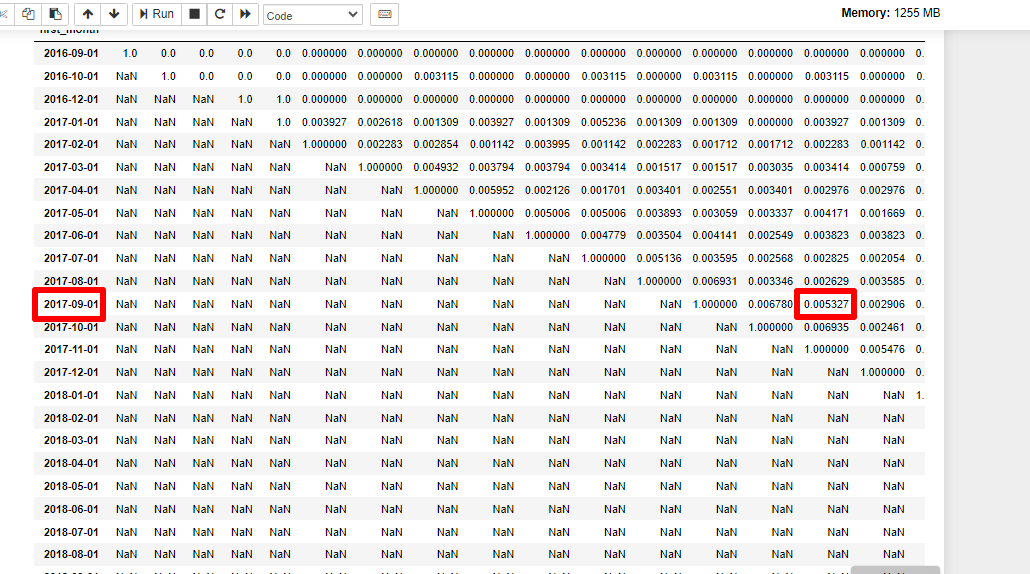

<a id="6"></a>
# Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

In [114]:
df_customers  = pd.read_csv('//mnt/HC_Volume_18315164/home-jupyter/jupyter-v-gavristov/olist_customers_dataset.csv') 
df_orders     = pd.read_csv('//mnt/HC_Volume_18315164/home-jupyter/jupyter-v-gavristov/olist_orders_dataset.csv')
df_items      = pd.read_csv('//mnt/HC_Volume_18315164/home-jupyter/jupyter-v-gavristov/olist_order_items_dataset.csv')

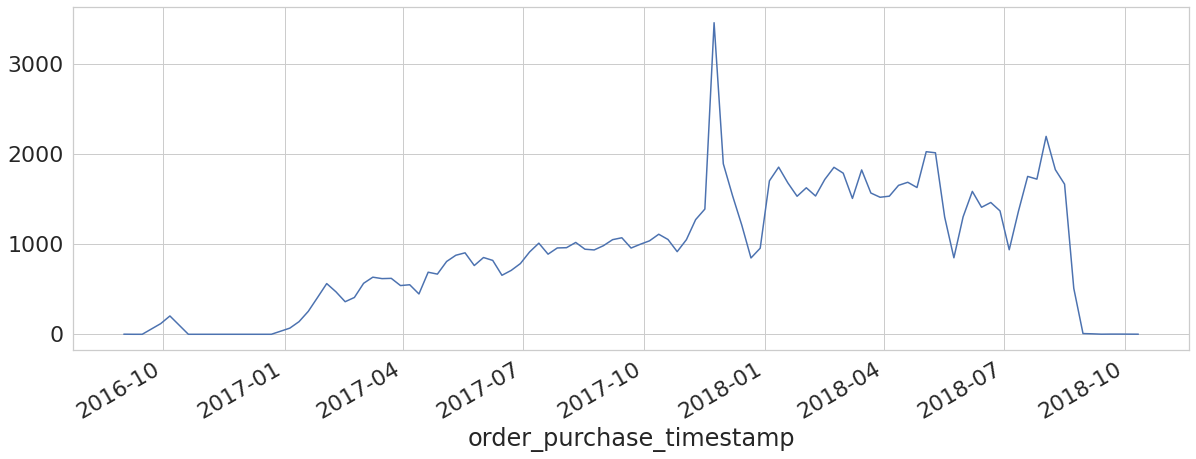

In [115]:
df_orders.order_purchase_timestamp = df_orders.order_purchase_timestamp.astype('datetime64[W]')
df_orders.groupby('order_purchase_timestamp').order_id.count().plot()

In [116]:
df_orders.groupby('order_purchase_timestamp').order_id.count().tail(10)

order_purchase_timestamp
2018-08-02    2195
2018-08-09    1826
2018-08-16    1665
2018-08-23     510
2018-08-30       9
2018-09-06       6
2018-09-13       2
2018-09-20       3
2018-09-27       3
2018-10-11       2
Name: order_id, dtype: int64

RFM анализ как-будто имеет смысл при наличии пула постоянных заказчиков с регулярными заказами.
В нашем датасете 90+% клиентов сделали 1 заказ, а значит понятия recenty и frequency вроде бы превращаются в тыкву.
Кроме того, судя по графику и его хвосту, RFM анализ еще имел смысл в середине августа 2018, после этого уже все было кончено.
Поэтому будем строить анализ на сентябрь 2018 за период с января 2018, в этом периоде бизнес в целом имел некоторе устоявшееся состояние. В предшествующие же периоды состояние дел явно серьезным образом отличалось. 

In [117]:
df_i = df_items.groupby('order_id', as_index = False)\
        .agg({'price':'sum'})\
        .rename(columns = {'price':'order_revenue'})
df_i

,order_id,order_revenue
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


In [118]:
df_o = df_orders.merge(df_i, on = 'order_id', how  ='left')[['order_id',
                                                          'customer_id',
                                                          'order_purchase_timestamp',
                                                          'order_revenue']]
df_o

,order_id,customer_id,order_purchase_timestamp,order_revenue
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-09-28,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-19,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-02,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-16,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-08,19.90
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09,72.00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-01,174.90
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-24,205.99
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-04,359.98


In [119]:
df = df_customers.merge(df_o, on = 'customer_id', how  ='left')
df = df.loc[df.order_purchase_timestamp >= '2018-01-01']\
       .loc[df.order_purchase_timestamp <= '2018-08-31']
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_revenue
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-11,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-17,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-08,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-26,230.00
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,2018-02-15,14.99
...,...,...,...,...,...,...,...,...
99432,f255d679c7c86c24ef4861320d5b7675,d111b06b6f3a2add0d2241325f65b5ca,13500,rio claro,SP,ca978d2459ea2c5ef6d5fde02be26b9c,2018-03-01,99.00
99434,f5a0b560f9e9427792a88bec97710212,b3e53d18a997f27a3ffd16da497eaf58,7790,cajamar,SP,97d6c1727b0d36b8d04035e35d86f40f,2018-05-17,124.90
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,2018-04-05,74.90
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-03-29,114.90


In [120]:
df = df.groupby('customer_unique_id', as_index = False)\
       .agg({'order_purchase_timestamp':'max', 'order_id':'count', 'order_revenue':'sum'})\
       .rename(columns = {'order_purchase_timestamp':'recency', 'order_id':'frequency', 'order_revenue': 'monetary'})

In [121]:
df.recency = pd.to_datetime(df.recency)

In [122]:
df.recency = pd.Timestamp("2018-09-01") - df.recency
df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,114 days,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121 days,1,18.90
2,0004bd2a26a76fe21f786e4fbd80607f,149 days,1,154.00
3,00050ab1314c0e55a6ca13cf7181fecf,135 days,1,27.99
4,00053a61a98854899e70ed204dd4bafe,191 days,1,382.00
...,...,...,...,...
52250,fff3e1d7bc75f11dc7670619b2e61840,44 days,1,54.85
52251,fff5eb4918b2bf4b2da476788d42051c,65 days,1,1050.00
52252,fff96bc586f78b1f070da28c4977e810,23 days,1,45.00
52253,fffcc512b7dfecaffd80f13614af1d16,149 days,1,688.00


In [123]:
df.recency = df.recency.astype('timedelta64[D]').astype(int)
df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,114,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,1,18.90
2,0004bd2a26a76fe21f786e4fbd80607f,149,1,154.00
3,00050ab1314c0e55a6ca13cf7181fecf,135,1,27.99
4,00053a61a98854899e70ed204dd4bafe,191,1,382.00
...,...,...,...,...
52250,fff3e1d7bc75f11dc7670619b2e61840,44,1,54.85
52251,fff5eb4918b2bf4b2da476788d42051c,65,1,1050.00
52252,fff96bc586f78b1f070da28c4977e810,23,1,45.00
52253,fffcc512b7dfecaffd80f13614af1d16,149,1,688.00


Расчитаем границы диапазонов для присвоения рейтинга по recency, frequency и monetary

In [124]:
quintiles = df[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 51.0, 0.4: 107.0, 0.6: 156.0, 0.8: 198.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.0, 0.4: 69.9, 0.6: 109.99, 0.8: 179.0}}

In [125]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [126]:
df['R'] = df['recency'].apply(lambda x: r_score(x))
df['F'] = df['frequency'].apply(lambda x: fm_score(x, 'frequency'))
df['M'] = df['monetary'].apply(lambda x: fm_score(x, 'monetary'))

Посмотрим на итоговую таблицу рейтингов

In [127]:
df

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,114,1,129.90,3,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,1,18.90,3,1,1
2,0004bd2a26a76fe21f786e4fbd80607f,149,1,154.00,3,1,4
3,00050ab1314c0e55a6ca13cf7181fecf,135,1,27.99,3,1,1
4,00053a61a98854899e70ed204dd4bafe,191,1,382.00,2,1,5
...,...,...,...,...,...,...,...
52250,fff3e1d7bc75f11dc7670619b2e61840,44,1,54.85,5,1,2
52251,fff5eb4918b2bf4b2da476788d42051c,65,1,1050.00,4,1,5
52252,fff96bc586f78b1f070da28c4977e810,23,1,45.00,5,1,2
52253,fffcc512b7dfecaffd80f13614af1d16,149,1,688.00,3,1,5


In [128]:
df['rfm_score'] = df['R'].map(str) + df['F'].map(str) + df['M'].map(str)
df

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,114,1,129.90,3,1,4,314
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,1,18.90,3,1,1,311
2,0004bd2a26a76fe21f786e4fbd80607f,149,1,154.00,3,1,4,314
3,00050ab1314c0e55a6ca13cf7181fecf,135,1,27.99,3,1,1,311
4,00053a61a98854899e70ed204dd4bafe,191,1,382.00,2,1,5,215
...,...,...,...,...,...,...,...,...
52250,fff3e1d7bc75f11dc7670619b2e61840,44,1,54.85,5,1,2,512
52251,fff5eb4918b2bf4b2da476788d42051c,65,1,1050.00,4,1,5,415
52252,fff96bc586f78b1f070da28c4977e810,23,1,45.00,5,1,2,512
52253,fffcc512b7dfecaffd80f13614af1d16,149,1,688.00,3,1,5,315


Самая печальная ситуация с frequency

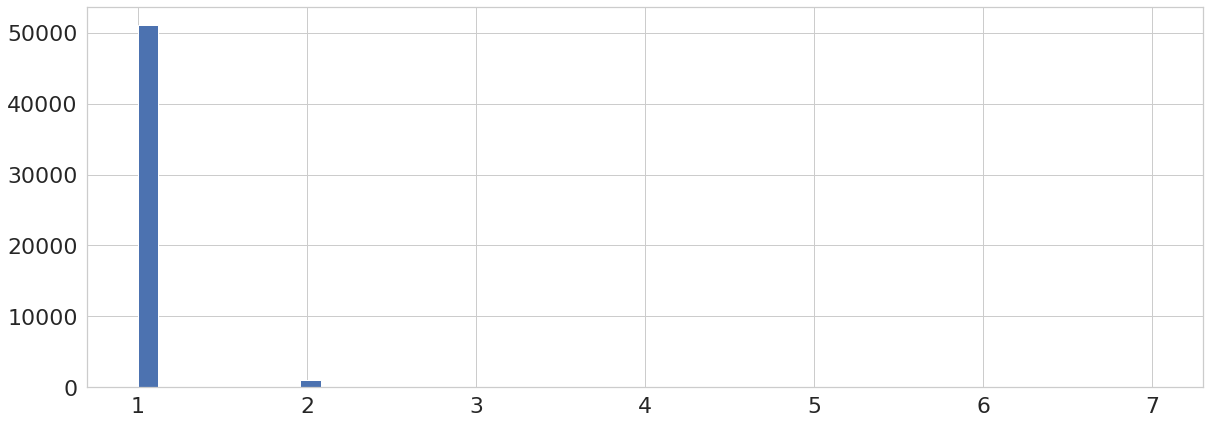

In [129]:
df.frequency.hist(bins = 50)

frequency оценивать бессмысленно, заказчиков, размещающих заказы регулярно у нас практически нет
поэтому будем смотреть на recency и monetary

In [130]:
segment = {
    r'[1-2][1-2]': 'дятлы! -(',
    r'[1-2][3-4]': 'ну если прямо нечем заняться',
    r'[1-2]5': 'забытые зайцы, надо звонить',
    r'3[1-2]': 'потеннциальные дятлы! -(',
    r'33': 'нужно попробовать',
    r'[3-4][4-5]': 'потенциальные зайцы!',
    r'41': 'копейки. по ходу дятлы',
    r'51': 'узнать не дятлы ли, случаем?',
    r'[4-5][2-3]': 'возможно, будущие заяцы',
    r'5[4-5]': 'зайцы!!!'
}

df['Segment'] = df['R'].map(str) + df['M'].map(str)
df['Segment'] = df['Segment'].replace(segment, regex=True)

In [131]:
df = df[['customer_unique_id', 'recency', 'monetary', 'rfm_score', 'Segment']]
df

,customer_unique_id,recency,monetary,rfm_score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,114,129.90,314,потенциальные зайцы!
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,18.90,311,потеннциальные дятлы! -(
2,0004bd2a26a76fe21f786e4fbd80607f,149,154.00,314,потенциальные зайцы!
3,00050ab1314c0e55a6ca13cf7181fecf,135,27.99,311,потеннциальные дятлы! -(
4,00053a61a98854899e70ed204dd4bafe,191,382.00,215,"забытые зайцы, надо звонить"
...,...,...,...,...,...
52250,fff3e1d7bc75f11dc7670619b2e61840,44,54.85,512,"возможно, будущие заяцы"
52251,fff5eb4918b2bf4b2da476788d42051c,65,1050.00,415,потенциальные зайцы!
52252,fff96bc586f78b1f070da28c4977e810,23,45.00,512,"возможно, будущие заяцы"
52253,fffcc512b7dfecaffd80f13614af1d16,149,688.00,315,потенциальные зайцы!


In [132]:
df.groupby('Segment').Segment.count()

Segment
возможно, будущие заяцы         8382
дятлы! -(                       8346
забытые зайцы, надо звонить     3743
зайцы!!!                        4293
копейки. по ходу дятлы          2021
ну если прямо нечем заняться    7403
нужно попробовать               2221
потеннциальные дятлы! -(        4676
потенциальные зайцы!            8958
узнать не дятлы ли, случаем?    2212
Name: Segment, dtype: int64